In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean, count, desc, min, max
import matplotlib.pyplot as plt


/home/djhoan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
#Su dung SparkSession de doc du lieu dau vao
spark = SparkSession.builder.appName("GBM").getOrCreate()

data = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load("Preprocessed1.csv")
data.cache()
data.count()


24/06/03 21:38:25 WARN Utils: Your hostname, djhoan-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/06/03 21:38:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/03 21:38:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


4243

In [3]:
#Hien thi schema du lieu
data.printSchema()

root
 |-- Num_of_reviews: double (nullable = true)
 |-- General_rate: double (nullable = true)
 |-- Comfort: double (nullable = true)
 |-- Interior design: double (nullable = true)
 |-- Performance: double (nullable = true)
 |-- Value for the money: double (nullable = true)
 |-- Exterior styling: double (nullable = true)
 |-- Reliability: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Brand_encoded: double (nullable = true)
 |-- Model_encoded: double (nullable = true)
 |-- Year_encoded: double (nullable = true)



In [4]:
from math import exp, sqrt

def sigmoid(x):
    return 1 / (1 + exp(-x))

def compute_gradient(tree, data):
    gradients = []
    for row in data:
        features = row[:-1]
        label = row[-1]
        prediction = predict(tree, features)
        gradient = label - prediction
        gradients.append((features, gradient))
    return gradients

def predict(tree, features):
    node = tree
    while isinstance(node, dict):
        if features[node['feature_index']] < node['threshold']:
            node = node['left']
        else:
            node = node['right']
    return node

def update_tree(tree, gradients, learning_rate):
    for features, gradient in gradients:
        node = tree
        while isinstance(node, dict):
            if features[node['feature_index']] < node['threshold']:
                node = node['left']
            else:
                node = node['right']
        node += learning_rate * gradient

In [5]:
# Xay dung 
def build_tree(data, depth=1, max_depth=3):
    if depth == max_depth or len(data) == 0:
        return sum([row[1] for row in data]) / len(data) if len(data) > 0 else 0
    
    feature_index = 0
    threshold = sum([row[0][feature_index] for row in data]) / len(data)
    
    left_data = [row for row in data if row[0][feature_index] < threshold]
    right_data = [row for row in data if row[0][feature_index] >= threshold]
    
    return {
        'feature_index': feature_index,
        'threshold': threshold,
        'left': build_tree(left_data, depth + 1, max_depth),
        'right': build_tree(right_data, depth + 1, max_depth)
    }

In [6]:
#Huan luyen
def train_gbm(data, num_trees=10, learning_rate=0.1, max_depth=3):
    trees = []
    predictions = [0.0] * len(data)
    
    for _ in range(num_trees):
        # Tính toán gradient
        gradients = []
        for i, row in enumerate(data):
            label = row[-1]
            gradient = label - sigmoid(predictions[i])
            gradients.append((row[:-1], gradient))
        
        # Huấn luyện cây trên gradient
        tree = build_tree(gradients, max_depth=max_depth)
        trees.append(tree)
        
        # Cập nhật dự đoán
        for i, row in enumerate(data):
            predictions[i] += learning_rate * predict(tree, row[:-1])
    
    return trees

In [7]:
#Chay
# Chuyển đổi DataFrame sang RDD
data_rdd = data.rdd.map(lambda row: (
    row['Num_of_reviews'], row['General_rate'], row['Comfort'], row['Interior design'], 
    row['Performance'], row['Value for the money'], row['Exterior styling'], 
    row['Reliability'], row['Year'], row['Brand'], row['Model'], row['General_rate']
))

# Huấn luyện mô hình GBM
num_trees = 10
learning_rate = 0.1
max_depth = 3

data_list = data_rdd.collect()
# Loại bỏ các giá trị None trong dữ liệu
clean_data = [row for row in data_list if None not in row]

trees = train_gbm(clean_data, num_trees=num_trees, learning_rate=learning_rate, max_depth=max_depth)

# Dự đoán
def predict_gbm(trees, features):
    prediction = 0
    for tree in trees:
        prediction += predict(tree, features)
    return sigmoid(prediction)

In [8]:
# Tính toán các độ đo lỗi
def calculate_metrics(trees, data):
    predictions = []
    actuals = []
    
    for row in data:
        features = row[:-1]
        actual = row[-1]
        prediction = predict_gbm(trees, features)
        predictions.append(prediction)
        actuals.append(actual)
    
    # Tính RMSE
    mse = sum([(p - a) ** 2 for p, a in zip(predictions, actuals)]) / len(actuals)
    rmse = sqrt(mse)
    
    # Tính MAE
    mae = sum([abs(p - a) for p, a in zip(predictions, actuals)]) / len(actuals)
    
    #Tinh R^2
    mean_actual = sum(actuals) / len(actuals)
    ss_total = sum([(a - mean_actual) ** 2 for a in actuals])
    ss_residual = sum([(a - p) ** 2 for a, p in zip(actuals, predictions)])
    r2 = 1 - (ss_residual / ss_total)
    
    return rmse, mae, r2

rmse, mae, r2 = calculate_metrics(trees, clean_data)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}%")


RMSE: 0.9998410073086619
MAE: 0.6006477191004613
R^2: 8.229719975061389e-05%


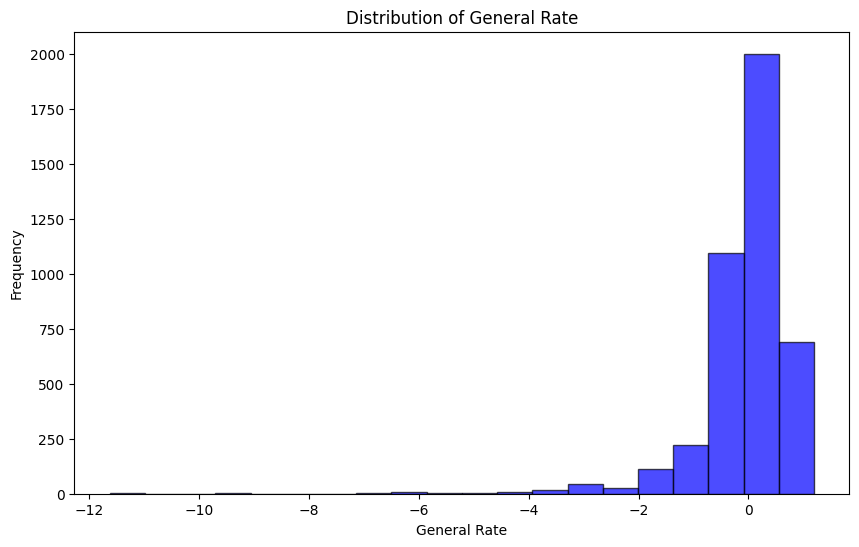

In [9]:
import matplotlib.pyplot as plt

# Chuyển đổi DataFrame sang RDD
data_rdd = data.rdd.map(lambda row: (
    row['Num_of_reviews'], row['General_rate'], row['Comfort'], row['Interior design'], 
    row['Performance'], row['Value for the money'], row['Exterior styling'], 
    row['Reliability'], row['Year'], row['Brand'], row['Model'], row['General_rate']
))

# Thu thập dữ liệu từ RDD
data_list = data_rdd.collect()

# Loại bỏ các giá trị None trong dữ liệu
clean_data = [row for row in data_list if None not in row]

# Lấy giá trị của General_rate
general_rates = [row[1] for row in clean_data]

# Biểu đồ histogram của General_rate
plt.figure(figsize=(10, 6))
plt.hist(general_rates, bins=20, alpha=0.7, color='b', edgecolor='black')
plt.xlabel('General Rate')
plt.ylabel('Frequency')
plt.title('Distribution of General Rate')
plt.show()


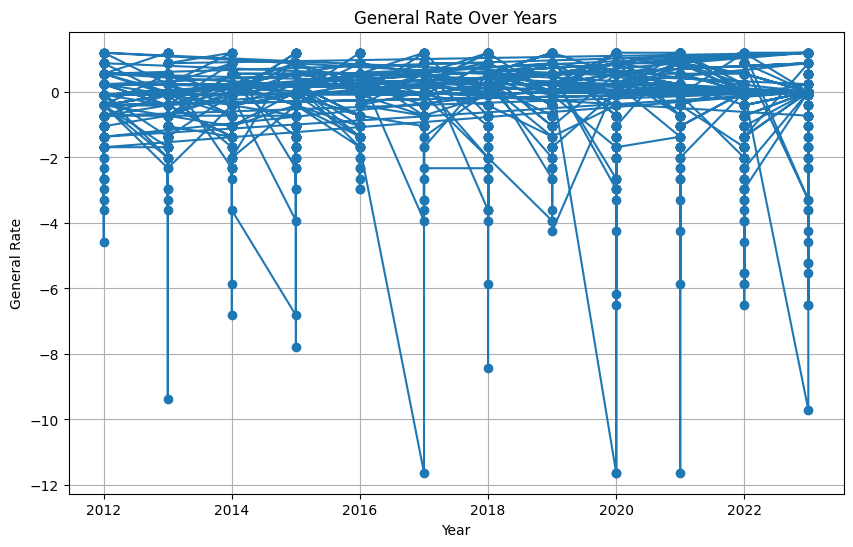

In [10]:
import matplotlib.pyplot as plt

# Chuyển đổi DataFrame sang RDD
data_rdd = data.rdd.map(lambda row: (
    row['Num_of_reviews'], row['General_rate'], row['Comfort'], row['Interior design'], 
    row['Performance'], row['Value for the money'], row['Exterior styling'], 
    row['Reliability'], row['Year'], row['Brand'], row['Model'], row['General_rate']
))

# Thu thập dữ liệu từ RDD
data_list = data_rdd.collect()

# Loại bỏ các giá trị None trong dữ liệu
clean_data = [row for row in data_list if None not in row]

# Lấy giá trị của General_rate
general_rates = [row[1] for row in clean_data]
years = [row[8] for row in clean_data]

# Biểu đồ line plot của General_rate theo năm
plt.figure(figsize=(10, 6))
plt.plot(years, general_rates, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('General Rate')
plt.title('General Rate Over Years')
plt.grid(True)
plt.show()


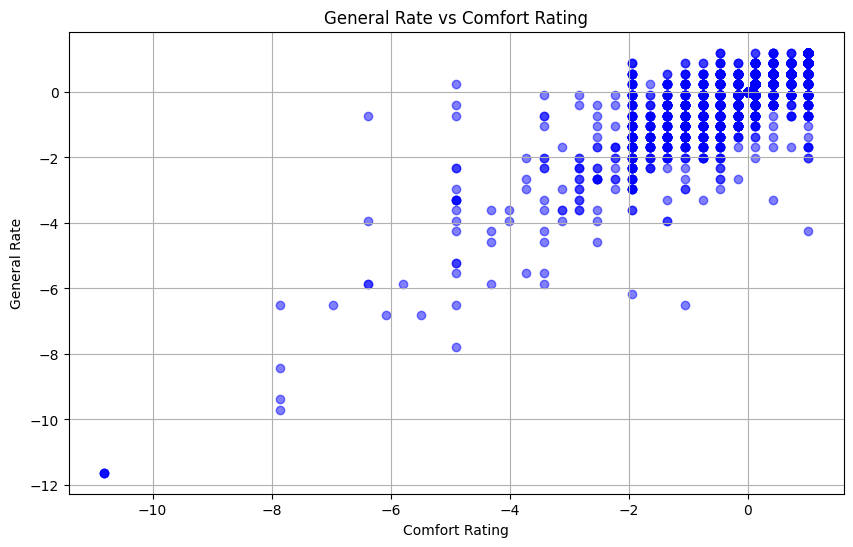

In [11]:
import matplotlib.pyplot as plt

# Chuyển đổi DataFrame sang RDD
data_rdd = data.rdd.map(lambda row: (
    row['Num_of_reviews'], row['General_rate'], row['Comfort'], row['Interior design'], 
    row['Performance'], row['Value for the money'], row['Exterior styling'], 
    row['Reliability'], row['Year'], row['Brand'], row['Model'], row['General_rate']
))

# Thu thập dữ liệu từ RDD
data_list = data_rdd.collect()

# Loại bỏ các giá trị None trong dữ liệu
clean_data = [row for row in data_list if None not in row]

# Lấy giá trị của General_rate và Comfort
general_rates = [row[1] for row in clean_data]
comfort_ratings = [row[2] for row in clean_data]

# Biểu đồ scatter plot của General_rate và Comfort
plt.figure(figsize=(10, 6))
plt.scatter(comfort_ratings, general_rates, color='b', alpha=0.5)
plt.xlabel('Comfort Rating')
plt.ylabel('General Rate')
plt.title('General Rate vs Comfort Rating')
plt.grid(True)
plt.show()
